In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from datetime import datetime
import matplotlib.pyplot as plt
from random import random
from itertools import product
import warnings

In [2]:
# Data reading
DATA_FOLDER = "Data/"

epinions = pd.read_table(DATA_FOLDER + 'soc-sign-epinions.txt', 
                         names=['Source','Target','Weight'],comment='#',header=None).rename_axis('Epinions',axis=1)
slashdot = pd.read_table(DATA_FOLDER + 'soc-sign-Slashdot090221.txt', 
                         names=['Source','Target','Weight'],comment='#',header=None).rename_axis('Slashdot',axis=1)
wikielec = pd.read_csv(DATA_FOLDER + 'wikipedia.csv').rename_axis('Wikipedia',axis=1)

In [3]:
# Display of the same structures datasets
display(epinions.head())
display(slashdot.head())
display(wikielec.head())

Epinions,Source,Target,Weight
0,0,1,-1
1,1,128552,-1
2,2,3,1
3,4,5,-1
4,4,155,-1


Slashdot,Source,Target,Weight
0,0,1,1
1,0,2,1
2,0,3,1
3,0,4,1
4,0,5,1


Wikipedia,Source,Target,Weight
0,3,30,1
1,25,30,-1
2,4,30,1
3,5,30,1
4,6,30,1


### First part - Weight average prediction

#### Idea

This prediction method is used to predict edges' weight locally. That means that we do not look at the overall structure of the graph but only at a few nodes. The idea behind this technique is simple. To predict the weight of an edge, we only look at the two nodes forming this edge as well as their connected edges. First, we calculate the average of weights of the outgoing edges for the source node. Then, we also calculate the average of weights of the ingoing edges for the target node. Finally we compare those two means:

- If both are positive, the predicted edge will be positive
- If both are negative, the predicted edge will be negative
- If the two means have different signs, the sign of the largest mean in absolute value will give the edge prediction

For example, if the average of outgoing edges is -0.7 and the average of ingoing edges is 0.3, the predicted edge will then be -1.

###### Why such an algorithm ?
The idea behind this algorithm is that both people's personnality and performance affects the final link between two people. In this algorithm, performance would typically be the average of ingoing weights for the target node and personnality would be the outgoing weights average for the source node. Personnality is important because people do not always rate other people based on an impersonal choice. For example, wikipedia adminiship voters should theoritically vote based on the candidate capability to be administrator and not based on anything else. Performance is important because it reflects how the target appears to other people. For example, on `epinions` dataset, people might be more trustworthy than others and give a general better impression to people. So this algorithm tries to predict edges based on people's performance and personnality and not based on subgraph connections like balance and status theories do.

#### Evaluation method
Before jumping into the algorithms, we will explain the method used to evaluate our results. We are in the case of a binary classifier (+1 and -1) so we need to evaluate both class. We could use a f-score evaluation but the problem is that this method only evaluates the psotive class (precision and recall on positives). So what we will use is the Matthews correlation coefficient which is given by:

$$ MCC=\frac{TP*TN-FP*FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}} $$

This coefficient gives a measure of the quality of a binary classification and will therefore be used to evaluate our predictions. We also give the precision, recall and f-score for each of the binary classes.

In [4]:
index = list(product(['+1', '-1'], ['Precision', 'Recall', 'F-score'])) + [("General","Accuracy"),("General","MCC")]

evaluation_results = pd.DataFrame(columns=["Epinions", "Slashdot", "Wikipedia"], 
                                  index=pd.MultiIndex.from_tuples(index, names=['Class', 'Score']))\
                                  .rename_axis('Evaluation results',axis=1)

display(evaluation_results)

Evaluation results Epinions Slashdot Wikipedia
Class   Score                                 
+1      Precision       NaN      NaN       NaN
        Recall          NaN      NaN       NaN
        F-score         NaN      NaN       NaN
-1      Precision       NaN      NaN       NaN
        Recall          NaN      NaN       NaN
        F-score         NaN      NaN       NaN
General Accuracy        NaN      NaN       NaN
        MCC             NaN      NaN       NaN

In [5]:
def weighted_average_evaluation(G):
    
    TP = TN = FP = FN = 0
    
    for e in G.edges:
        if G.edges[e]['Weight'] == G.edges[e]['Predict']:
            if G.edges[e]['Weight'] > 0:
                TP += 1
            else:
                TN += 1
        else:
            if G.edges[e]['Predict'] > 0:
                FP += 1
            else:
                FN += 1
    
    precision_pos = TP/(TP+FP)
    recall_pos    = TP/(TP+FN)
    precision_neg = TN/(TN+FN)
    recall_neg    = TN/(TN+FP)
    F_score_pos = (2*precision_pos*recall_pos/(precision_pos + recall_pos)) if precision_pos + recall_pos != 0 else 0
    F_score_neg = (2*precision_neg*recall_neg/(precision_neg + recall_neg)) if precision_neg + recall_neg != 0 else 0
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    
    if TP*TN*FP*FN == 0:
        MCC = 0
    else:
        MCC = (TP*TN - FP*FN)/np.sqrt(float((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)))
    
    return (precision_pos, recall_pos, F_score_pos, 
            precision_neg, recall_neg, F_score_neg,
            accuracy, MCC)
    

    

#### First algorithm
The first algorithm `average_predict` is the one we have described above. It will first calculate the mean of outgoing weights and ingoing weights for every nodes and store them as attributes `Source score` and `Target score`. Then, for every edges, it will compare the source node score (average outgoing weights) and target node score (average ingoing weights) and predict the sign as explained above. Note that this is not a real case of prediction as we also count the weight of the edge that we want to predict in the averages. This first algorithm is implemented to get a first impression of the results that we could get. Furthermore, it is much faster than the next agorithms so we will use this speed to find some parameters in the next steps.

In [6]:
def average_predict(dataframe):
    # Dataframe to Graph
    G = nx.from_pandas_edgelist(dataframe, source="Source", target="Target", 
                                edge_attr=["Weight"], create_using=nx.DiGraph())

    # Set source and target nodes attribute (ingoing and outgoing averages)
    for node in G.nodes:
        out_edges_weight = [G.get_edge_data(*e)['Weight'] for e in G.out_edges(node)]
        in_edges_weight  = [G.get_edge_data(*e)['Weight'] for e in G.in_edges(node)]
        G.nodes[node]["Source score"] = np.mean(out_edges_weight) if len(out_edges_weight) > 0 else np.nan
        G.nodes[node]["Target score"] = np.mean(in_edges_weight)  if len(in_edges_weight)  > 0 else np.nan

    # Compare node attributes for each edges
    for e in G.edges:
        # Retrieve node attributes
        s = G.nodes[e[0]]['Source score']
        t = G.nodes[e[1]]['Target score']
        if np.isnan(s) or np.isnan(t):
            raise ValueError("nan sould not be there")
        
        # Case where source and target weight averages have same signs
        if s*t > 0:
            # Both are positive
            if s > 0:
                G.edges[e]["Predict"] = 1
            # Both are negative
            else:
                G.edges[e]["Predict"] = -1
        
        # Case where source and target weight averages have opposite signs
        elif s*t < 0:
            if s > 0:
                # Get the largest of the two averages (absolute value)
                if s > abs(t):
                    G.edges[e]["Predict"] = 1
                elif s < abs(t):
                    G.edges[e]["Predict"] = -1
                # Both are equal -> we guess
                else:
                    G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
            else:
                # Get the largest of the two averages (absolute value)
                if abs(s) > t:
                    G.edges[e]["Predict"] = -1
                elif abs(s) < t:
                    G.edges[e]["Predict"] = 1
                # Both are equal -> we guess
                else:
                    G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
                    
        # Case where one of the two source and target weight averages is 0
        else:
            if s + t > 0:
                G.edges[e]["Predict"] = 1
            elif s + t < 0:
                G.edges[e]["Predict"] = -1
            else:
                G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
    
    # Evaluation
    return weighted_average_evaluation(G)

In [7]:
%time evaluation_results["Epinions"] = average_predict(epinions)

CPU times: user 13.6 s, sys: 158 ms, total: 13.7 s
Wall time: 13.7 s


In [8]:
%time evaluation_results["Slashdot"] = average_predict(slashdot)

CPU times: user 8.8 s, sys: 71.3 ms, total: 8.88 s
Wall time: 8.88 s


In [9]:
%time evaluation_results["Wikipedia"] = average_predict(wikielec)

CPU times: user 1.44 s, sys: 7.7 ms, total: 1.45 s
Wall time: 1.45 s


In [10]:
display(evaluation_results.round(decimals=3))

Evaluation results  Epinions  Slashdot  Wikipedia
Class   Score                                    
+1      Precision      0.948     0.879      0.859
        Recall         0.998     0.985      0.992
        F-score        0.972     0.929      0.921
-1      Precision      0.980     0.915      0.932
        Recall         0.684     0.537      0.396
        F-score        0.806     0.677      0.556
General Accuracy       0.951     0.884      0.866
        MCC            0.795     0.644      0.554

#### Discussion
We can see that the accuracies of our predictions for all datasets are already surprisingly good. But. The problem with our datasets is that they contain a lot more positive edges than negative ones. So the average of weights will more often be positve because there are just more positive edges. If we exagerate the idea, it's just as if we put all weights to +1 so that, as the positive weights are dominant, the accuracy will be high. This is why we need a binary class evaluation method to also evaluate the negative weight predictions. This evaluation problem can easily be resolved if we look at the recall on negative evaluations and see that they are low compared to the other evaluations. Having a low recall on negative weights simply means that there are too much false positives which means that too many weights were predicted to be positive as they were in reality negative.

#### Second algorithm
To adress the problem of unbalanced classes, we added a new parameter to restore the balance. As we have seen before, the problem is that the negative weights are under-represented. So we added a parameter `alpha` to ponderate the classes and which quantifies the importance of the negative weights class. This parameter range is between 0 and 1. For example, `alpha=1` would mean that you give all importance to negative weights. This would results in predicting that all edges are equal to -1. The same reasoning applies when `alpha=0` which leads to predicting that all edges are equal to 1.

So the following algorithm takes as parameter `alpha`. It is the exact same algorithm than the previous one except that it adds a new edge attribute `Modified Weight` which contains the ponderated weights. So, the modified weights are as follow:

\begin{alignat*}{2}
+1 &\rightarrow +1*(1-\alpha) \\
-1 &\rightarrow -1*(\alpha)
\end{alignat*}



In [11]:
def weighted_average_predict(dataframe, alpha):
    G = nx.from_pandas_edgelist(dataframe, source="Source", target="Target", 
                                edge_attr=["Weight"], create_using=nx.DiGraph())
    
    # Edge ponderation
    for e in G.edges:
        G.edges[e]['Modified Weight'] = (1-alpha) if G.edges[e]['Weight'] > 0 else -alpha
    
    # Average considering the modified weight
    for node in G.nodes:
        out_edges_weight = [G.get_edge_data(*e)['Modified Weight'] for e in G.out_edges(node)]
        in_edges_weight  = [G.get_edge_data(*e)['Modified Weight'] for e in G.in_edges(node)]
        G.nodes[node]["Source score"] = np.mean(out_edges_weight) if len(out_edges_weight) > 0 else np.nan
        G.nodes[node]["Target score"] = np.mean(in_edges_weight)  if len(in_edges_weight)  > 0 else np.nan


    for e in G.edges:
        s = G.nodes[e[0]]['Source score']
        t = G.nodes[e[1]]['Target score']
        if np.isnan(s) or np.isnan(t):
            raise ValueError("nan cannot exist here")

        if s*t > 0:
            if s > 0:
                G.edges[e]["Predict"] = 1
            else:
                G.edges[e]["Predict"] = -1

        elif s*t < 0:
            if s > 0:
                if s > abs(t):
                    G.edges[e]["Predict"] = 1
                elif s < abs(t):
                    G.edges[e]["Predict"] = -1
                else:
                    G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
            else:
                if abs(s) > t:
                    G.edges[e]["Predict"] = -1
                elif abs(s) < t:
                    G.edges[e]["Predict"] = 1
                else:
                    G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)

        else:
            if s + t > 0:
                G.edges[e]["Predict"] = 1
            elif s + t < 0:
                G.edges[e]["Predict"] = -1
            else:
                G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)

    return weighted_average_evaluation(G)

#### Gradient descent

To look for a the right parameter `alpha`, we implemented the following gradient descent algorithm. The parameter to optimize is `alpha` and the loss function is based on Matthews correlation coefficient (MCC). We want to find the optimal parameter `alpha` such that the MCC is maximized. Unfortunately, it is very sensible to parameters such as the learning rate and the initial parameters so it is hardly generalizable to all datasets. Furthermore, it oftens fall into local minimums which, in the end, will not give the optimal `alpha`.

Here is an example of some iterations from the algorithm where it converges to the optimal value. The initial parameters are 2 instances of `alpha`. We know that the ponderation has to be towards the negative weights so we can initialize the `alpha` instances to 0.5 and 0.55. The loss function is initialized to its optimal 1. Finally, the learning rate used here is 1 and the algorithm stops when the difference of two consecutives `alpha` is less than 1e-4.

In [12]:
delta = np.inf
alpha_prec = 0.5
alpha = 0.55
gamma = 1
f = 1
while delta > 1e-4:
    f_prec = weighted_average_predict(wikielec, alpha_prec)
    f = weighted_average_predict(wikielec, alpha)
    alpha_new = alpha + gamma*(f[-1]-f_prec[-1])
    delta = abs(alpha_new - alpha)
    alpha_prec = alpha
    alpha = alpha_new
    print("alpha_new:",alpha_new)
    print("Delta:",delta,"\n")
print("alpha optimal:", alpha_new)
print("MCC for the optimal alpha:", f[-1])

alpha_new: 0.6016060508481715
Delta: 0.05160605084817149 

alpha_new: 0.6370826226850989
Delta: 0.03547657183692732 

alpha_new: 0.6538446743130801
Delta: 0.016762051627981278 

alpha_new: 0.6591776550509444
Delta: 0.005332980737864257 

alpha_new: 0.6599432943246093
Delta: 0.0007656392736649087 

alpha_new: 0.6604409554633216
Delta: 0.000497661138712302 

alpha_new: 0.6601242501609728
Delta: 0.00031670530234884087 

alpha_new: 0.6601916342643964
Delta: 6.738410342366219e-05 

alpha optimal: 0.6601916342643964
MCC for the optimal alpha: 0.6644898458528367


So we find that the optimal value for `alpha` is 0.664. We find the optimal `alpha` for other datasets by iterating by hand because, in the end, it takes more time to find the good parameters to get the optimal value than just iterating by ourselves.

We can also plot the MCC coefficients for different `alpha` and different datasets to illustrate the behaviour of the parameter: 

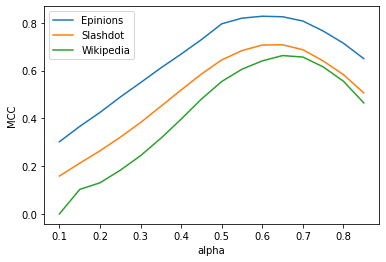

In [37]:
plt.figure()
alphas = np.arange(0.1,0.9,0.05)
for df in [epinions, slashdot, wikielec]:
    MCC = [0]*len(alphas)
    for i,alpha in enumerate(alphas):
        (_,_,_,_,_,_,_,MCC[i]) = weighted_average_predict(df, alpha)
    plt.plot(alphas,MCC)
    
plt.legend(("Epinions", "Slashdot", "Wikipedia"))
plt.xlabel("alpha")
plt.ylabel("MCC")
plt.show()

In [13]:
evaluation_results2 = evaluation_results.copy()
evaluation_results2 = evaluation_results2.rename_axis("Evaluation results 2.0", axis=1)

In [14]:
# Optimal alpha found by hand: 0.63
%time evaluation_results2["Epinions"] = weighted_average_predict(epinions, 0.63)

CPU times: user 15.2 s, sys: 118 ms, total: 15.3 s
Wall time: 15.3 s


In [15]:
# Optimal alpha found by hand: 0.63
%time evaluation_results2["Slashdot"] = weighted_average_predict(slashdot, 0.63)

CPU times: user 9.99 s, sys: 73.4 ms, total: 10.1 s
Wall time: 10.1 s


In [16]:
# Optimal alpha found by gradient descent: 0.66
%time evaluation_results2["Wikipedia"] = weighted_average_predict(wikielec, 0.66)

CPU times: user 1.71 s, sys: 8.87 ms, total: 1.72 s
Wall time: 1.72 s


In [17]:
display(evaluation_results.round(decimals=3))
display(evaluation_results2.round(decimals=3))

Evaluation results  Epinions  Slashdot  Wikipedia
Class   Score                                    
+1      Precision      0.948     0.879      0.859
        Recall         0.998     0.985      0.992
        F-score        0.972     0.929      0.921
-1      Precision      0.980     0.915      0.932
        Recall         0.684     0.537      0.396
        F-score        0.806     0.677      0.556
General Accuracy       0.951     0.884      0.866
        MCC            0.795     0.644      0.554

Evaluation results 2.0  Epinions  Slashdot  Wikipedia
Class   Score                                        
+1      Precision          0.970     0.934      0.924
        Recall             0.981     0.935      0.938
        F-score            0.975     0.934      0.931
-1      Precision          0.883     0.777      0.755
        Recall             0.821     0.773      0.712
        F-score            0.851     0.775      0.733
General Accuracy           0.958     0.898      0.890
        MCC                0.827     0.709      0.664

#### Sanity check
Just to verifiy that our algorithm gives plausible results, we can see that when we use an `alpha` parameter of 0 or 1, the accuracy becomes equal to the percentage of positive (`alpha=0`) and negative (`alpha=1`) edges in the datasets:

In [45]:
print("Accuracy: %.1f%%"% (weighted_average_predict(epinions, 0)[-2]*100))

Accuracy: 85.4%


In other words, what we just did is to predict that all edges are positive. Because there are 85.4% of positive edges in `epinions`, the accuracy becomes 85.4% as well. Note that in our last algorithm, the accuracy increased more than 10% with respect to the percentage of positive edges through all datasets.

#### Discussion
###### Score improvements
The second table shows our new results compared to the older ones (first table). Now that the classes are balanced, the results are much better. We can see that all f-score increased when using a weight ponderation, especially the f-scores for the negative class. This is due to the fact that the recall for negative class has significantly increased. The cost of this is that the precision for negative class decreased but this decrease is lower than the recall inccrease making the overall statistics better. The higher recall for negative class also induced a balancing of precision and recall for the positive class which are now very close. The accuracy didn't increase much which is normal because we tried to balance the predictions rather than improve the number of correct predictions. 

###### Mystery coefficient
Surprisingly, we can see that the optimal `alpha` parameter is pretty constant through the datasets (around 0.65). But what does this coefficient represent concretely ? At first, we chose this coefficient to balance the positive and negative classes. But intuitively, the optimal coefficient would be based on the ratio of positive and negative edges. For example, if there are 85% of positive edges like in `epinions`, the intuition would be to give a weight of 0.85 to the negative weights (`alpha=0.85`) and 0.15 to the positive ones. But this is not the case here. All `alpha` from the different datasets are underestimated with respect to this intuition. Indeed, the percentage of positive edges for `epinions`, `slashdot` and `wikielec` are respectively 85.0%,	77.4% and 78.7% which are all way above our optimal parameter found of 0.65. What is even more surprising is how this optimal `alpha` keeps constant with different datasets and different ratios of positive/negative edges. This consistency goes toward the idea that this coefficient could have a broader signification. The first concrete hypothesis on the meaning of this coefficient would be that  **negative votes/ratings have more ease to tilt the scales than positive ones**. In other words, it confirms the fact that graphs often contain communities of condensed positives links where those communities are seperated by negative links. Indeed, it means that positive links are usually very condensed around nodes and that the average of outgoing/ingoing edges will definitely be positive (close to 1). On the other hand, negative links are often alone or close to a few postive links which make them a hard opponent against the positive links. So, as positive links are more condensed than negative ones, only a low `alpha` coefficient is required to make the negative links confrontable with positive links.

###### Winner Dataset
Even if `Wikipedia` has the lowest prediction scores in general, it is the dataset where the weight ponderation worked the best. This is very interesting as Wikipedia is indeed different from the other datasets. Its links are votes for adminship whereas the other datasets' links are more similar to "user ratings". If we consider the hypothesis stated above, that means that `Wikipedia` is the dataset which forms the most communities of positive votes. In other words, that means that votes are mostly oriented towards the same candidates and all other candidates only have a small impact on electors.
###### Further research
Some further research could be made based on the same idea of algorithm.
- A first idea could be to also ponderate source and target nodes. For example, when comparing the avergage of outgoing edges from source and ingoing edges to target, we could give a higher importance to the target ingoing edges. We tried to implement this additional parameter but we only found optimals of 0.5 (equal importance), but maybe it couuld be an important factor on other datasets.   
- A second idea was to use the time at which the edges were formed a give a decreasing exponential weight to links formed further away in time. In could be interesting to test this idead on several temporal signed networks and compare them.

### Second Part - Real predicitons 

The last prediction algorithm that we have seen is not a real prediction algorithm as it also used the edge to predict in the averages. But the purpose of the previous part was mostly to understand the parameters and how to use them. Now, we will implement a real "Leave One Out" algorithm where we do not consider the weight of the edge that we want to predict and where we predict one edge at a time, knowing all the reamining graph. We then iterate through all edges and predict their weights. This algorithm complexity is higher than the previous one and this is why the parameters search was mostly done with the previous algorithm. Fortunately, the assumptions made previously still hold with this algorithm. What changed here is that we cannot compute the source and target score attributes as we did before so we need to calculate the averages on each edge, which is why it takes more time.

In [52]:
def lvo_weighted_average_predict(dataframe, alpha):
    G = nx.from_pandas_edgelist(dataframe, source="Source", target="Target", 
                                edge_attr=["Weight"], create_using=nx.DiGraph())
    
    for e in G.edges:
        G.edges[e]['Modified Weight'] = (1-alpha) if G.edges[e]['Weight'] > 0 else -alpha
    
    for e in G.edges:
        # Calculate outgoing and ingoing weight averages for each edge without taking into account the edge to predict
        out_edges_weight = [G.get_edge_data(*edge)['Modified Weight'] for edge in G.out_edges(e[0]) if edge != e]
        in_edges_weight  = [G.get_edge_data(*edge)['Modified Weight'] for edge in G.in_edges(e[1])  if edge != e]
        
        # Lengths of source outgoing and target ingoing edge lists
        len_out = len(out_edges_weight)
        len_in  = len(in_edges_weight)
        
        # If both list lengths are 0 -> guess
        if 0 == len_out == len_in:
            G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
        # If one of the two list lengths is 0 -> only consider one
        elif len_out == 0:
            t = np.mean(in_edges_weight)
            if t > 0:
                G.edges[e]["Predict"] = 1
            elif t < 0:
                G.edges[e]["Predict"] = -1
            # Case where t=0 -> guess
            else:
                 G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
        elif len_in == 0:
            s = np.mean(out_edges_weight)
            if s > 0:
                G.edges[e]["Predict"] = 1
            elif s < 0:
                G.edges[e]["Predict"] = -1
            # Case where s=0 -> guess
            else:
                 G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
        # Case where both list lenghts are above 0 -> same as previous algo
        else:
            s = np.mean(out_edges_weight)
            t = np.mean(in_edges_weight)
            if s*t > 0:
                if s > 0:
                    G.edges[e]["Predict"] = 1
                else:
                    G.edges[e]["Predict"] = -1

            elif s*t < 0:
                if s > 0:
                    if s > abs(t):
                        G.edges[e]["Predict"] = 1
                    elif s < abs(t):
                        G.edges[e]["Predict"] = -1
                    else:
                        G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
                else:
                    if abs(s) > t:
                        G.edges[e]["Predict"] = -1
                    elif abs(s) < t:
                        G.edges[e]["Predict"] = 1
                    else:
                        G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)

            else:
                if s + t > 0:
                    G.edges[e]["Predict"] = 1
                elif s + t < 0:
                    G.edges[e]["Predict"] = -1
                else:
                    G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)

    return weighted_average_evaluation(G)

In [53]:
evaluation_results3 = evaluation_results.copy()
evaluation_results3 = evaluation_results3.rename_axis("Evaluation results 3.0", axis=1)

In [54]:
# Optimal alpha found by hand: 0.64
%time evaluation_results3["Epinions"] = lvo_weighted_average_predict(epinions, 0.64)

CPU times: user 4min 28s, sys: 791 ms, total: 4min 29s
Wall time: 4min 29s


In [55]:
# Optimal alpha found by hand: 0.64
%time evaluation_results3["Slashdot"] = lvo_weighted_average_predict(slashdot, 0.64)

CPU times: user 2min 5s, sys: 340 ms, total: 2min 5s
Wall time: 2min 5s


In [56]:
# Optimal alpha found by hand: 0.67
%time evaluation_results3["Wikipedia"] = lvo_weighted_average_predict(wikielec, 0.67)

CPU times: user 15.5 s, sys: 39.2 ms, total: 15.5 s
Wall time: 15.5 s


In [57]:
display(evaluation_results2.round(decimals=3))
display(evaluation_results3.round(decimals=3))

Evaluation results 2.0  Epinions  Slashdot  Wikipedia
Class   Score                                        
+1      Precision          0.970     0.934      0.924
        Recall             0.981     0.935      0.938
        F-score            0.975     0.934      0.931
-1      Precision          0.883     0.777      0.755
        Recall             0.821     0.773      0.712
        F-score            0.851     0.775      0.733
General Accuracy           0.958     0.898      0.890
        MCC                0.827     0.709      0.664

Evaluation results 3.0  Epinions  Slashdot  Wikipedia
Class   Score                                        
+1      Precision          0.955     0.913      0.915
        Recall             0.962     0.899      0.917
        F-score            0.959     0.906      0.916
-1      Precision          0.769     0.672      0.690
        Recall             0.740     0.707      0.684
        F-score            0.754     0.689      0.687
General Accuracy           0.929     0.856      0.868
        MCC                0.713     0.596      0.603

First of all, we can see that even though we tried to find the best parameters by hand, they stay very close to the ones we found before which confirms our hypothesis that this coefficient might be generalizable.

Second of all, we can see that the prediction performs less well than before mostly because this time, we didn't take into account the edge that we want to predict. The most affected score is the recall for the negative class just as before. Based on the MCC coefficient, we also see that the less affected dataset is `Wikipedia`.

In [73]:
def wpo_weighted_average_predict(dataframe, alpha, test_percent):
    
    df = dataframe.sample(round(test_percent*dataframe.shape[0])) 

    G = nx.from_pandas_edgelist(dataframe, source="Source", target="Target", 
                                edge_attr=["Weight"], create_using=nx.DiGraph())
    
    G_unknown = nx.from_pandas_edgelist(df, source="Source", target="Target", 
                                edge_attr=["Weight"], create_using=nx.DiGraph())

    for e in G.edges:
        if e in G_unknown.edges:
            G.edges[e]['Modified Weight'] = np.nan
        else:
            G.edges[e]['Modified Weight'] = (1-alpha) if G.edges[e]['Weight'] > 0 else -alpha
        
    for node in G_unknown.nodes:
        out_edges_weight = [G.get_edge_data(*e)['Modified Weight'] for e in G.out_edges(node)]
        in_edges_weight  = [G.get_edge_data(*e)['Modified Weight'] for e in G.in_edges(node)]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            G_unknown.nodes[node]["Source score"] = np.nanmean(out_edges_weight)
            G_unknown.nodes[node]["Target score"] = np.nanmean(in_edges_weight)
            
    for e in G_unknown.edges:
        s = G_unknown.nodes[e[0]]['Source score']
        t = G_unknown.nodes[e[1]]['Target score']
        if np.nan == s == t:
            G_unknown.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
        elif s == np.nan:
            if t > 0:
                G_unknown.edges[e]["Predict"] = 1
            elif t < 0:
                G_unknown.edges[e]["Predict"] = -1
            else:
                G_unknown.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
        elif t == np.nan:
            if s > 0:
                G_unknown.edges[e]["Predict"] = 1
            elif s < 0:
                G_unknown.edges[e]["Predict"] = -1
            else:
                G_unknown.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
        else:
            if s*t > 0:
                if s > 0:
                    G_unknown.edges[e]["Predict"] = 1
                else:
                    G_unknown.edges[e]["Predict"] = -1

            elif s*t < 0:
                if s > 0:
                    if s > abs(t):
                        G_unknown.edges[e]["Predict"] = 1
                    elif s < abs(t):
                        G_unknown.edges[e]["Predict"] = -1
                    else:
                        G_unknown.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
                else:
                    if abs(s) > t:
                        G_unknown.edges[e]["Predict"] = -1
                    elif abs(s) < t:
                        G_unknown.edges[e]["Predict"] = 1
                    else:
                        G_unknown.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
            else:
                if s + t > 0:
                    G_unknown.edges[e]["Predict"] = 1
                elif s + t < 0:
                    G_unknown.edges[e]["Predict"] = -1
                else:
                    G_unknown.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
#
    #TP = TN = FP = FN = 0
    #
    #for e in G_unknown.edges:
    #    if G_unknown.edges[e]['Weight'] == G_unknown.edges[e]['Predict']:
    #        if G_unknown.edges[e]['Weight'] > 0:
    #            TP += 1
    #        else:
    #            TN += 1
    #    else:
    #        if G_unknown.edges[e]['Predict'] > 0:
    #            FP += 1
    #        else:
    #            FN += 1
    #
    #precision_pos = TP/(TP+FP)
    #recall_pos    = TP/(TP+FN)
    #precision_neg = TN/(TN+FN)
    #recall_neg    = TN/(TN+FP)
    #F_score_pos = (2*precision_pos*recall_pos/(precision_pos + recall_pos)) if precision_pos + recall_pos != 0 else 0
    #F_score_neg = (2*precision_neg*recall_neg/(precision_neg + recall_neg)) if precision_neg + recall_neg != 0 else 0
    #accuracy = (TP+TN)/(TP+TN+FP+FN)
    #
    #if TP*TN*FP*FN == 0:
    #    MCC = 0
    #else:
    #    MCC = (TP*TN - FP*FN)/np.sqrt(float((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)))
    #
    #return (precision_pos, recall_pos, F_score_pos, 
    #        precision_neg, recall_neg, F_score_neg,
    #        accuracy, MCC)
    return weighted_average_evaluation(G_unknown)

In [74]:
evaluation_results4 = evaluation_results.copy()
evaluation_results4 = evaluation_results4.rename_axis("Evaluation results 4.0", axis=1)

In [87]:
%time evaluation_results4["Epinions"] = wpo_weighted_average_predict(epinions, 0.64, 0.2)

CPU times: user 13.1 s, sys: 127 ms, total: 13.2 s
Wall time: 13.1 s


In [88]:
%time evaluation_results4["Slashdot"] = wpo_weighted_average_predict(slashdot, 0.64, 0.2)

CPU times: user 8.63 s, sys: 90.4 ms, total: 8.72 s
Wall time: 8.68 s


In [89]:
%time evaluation_results4["Wikipedia"] = wpo_weighted_average_predict(wikielec, 0.67, 0.2)

CPU times: user 1.21 s, sys: 3.08 ms, total: 1.21 s
Wall time: 1.21 s


In [90]:
display(evaluation_results3.round(decimals=3))
display(evaluation_results4.round(decimals=3))

Evaluation results 3.0  Epinions  Slashdot  Wikipedia
Class   Score                                        
+1      Precision          0.955     0.913      0.915
        Recall             0.962     0.899      0.917
        F-score            0.959     0.906      0.916
-1      Precision          0.769     0.672      0.690
        Recall             0.740     0.707      0.684
        F-score            0.754     0.689      0.687
General Accuracy           0.929     0.856      0.868
        MCC                0.713     0.596      0.603

Evaluation results 4.0  Epinions  Slashdot  Wikipedia
Class   Score                                        
+1      Precision          0.952     0.904      0.915
        Recall             0.918     0.860      0.908
        F-score            0.935     0.882      0.911
-1      Precision          0.607     0.587      0.665
        Recall             0.735     0.684      0.686
        F-score            0.665     0.632      0.675
General Accuracy           0.891     0.821      0.861
        MCC                0.604     0.517      0.587